# Customer Churn Prediction - Awari

A taxa de churn é uma métrica crítica da satisfação do cliente. Baixas taxas de churn significam clientes satisfeitos; altas taxas de rotatividade significam que os clientes estão deixando você. Uma pequena taxa de compostos de rotatividade mensal/trimestral ao longo do tempo, com 1% de churn mensal rapidamente se traduz em quase 12% de churn anual.


Churn é um bom indicador de potencial de crescimento. As taxas de churn rastreiam clientes perdidos e as taxas de crescimento rastreiam novos clientes—comparar e analisar essas duas métricas informa exatamente quanto sua empresa está crescendo ao longo do tempo. Se o crescimento for maior que o churn, você pode dizer que seu negócio está crescendo. Se o churn for maior que o crescimento, seu negócio está ficando menor.

## Importando as bibliotecas necessárias

In [ ]:
import pandas as pd 
pd.set_option( 'display.max_columns' , None )

import numpy as np 
import plotly.express as px
import matplotlib.pyplot as plt  
import seaborn as sns 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, plot_confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

In [ ]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


## Guardando o dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab/Data Science/Datasets/Customer-Churn.csv')

## Criando uma função de visualização geral dos dados

In [ ]:
def dataoveriew(df, message):
    print(f'{message}:\n')
    print('Número de linhas: ', df.shape[0])
    print("\nNúmero de colunas:", df.shape[1])
    print("\nNomes das colunas:")
    print(df.columns.tolist())
    print("\nValores faltantes:", df.isnull().sum().values.sum())
    print("\nValores únicos:")
    print(df.nunique())

In [ ]:
dataoveriew(df, 'Composição geral dos dados')

Composição geral dos dados:

Número de linhas:  7043

Número de colunas: 21

Nomes das colunas:
['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Valores faltantes: 0

Valores únicos:
customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64


In [ ]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Verificando a distribuição da variável alvo de Churn

In [ ]:
target = df["Churn"].value_counts().to_frame() 
target = target.reset_index() 
target = target.rename(columns={'index':'Category' }) 
fig = px.pie(target, values='Churn', names='Category', color_discrete_sequence=["black", "red"], 
             title= 'Distribuição de Churn' ) 
fig.show()

## Análise Exploratória de dados

Criando uma função que transforma as informações das variáveis em um dataframe.

In [ ]:
def map_df(features, df):

  # criando um dicionário para receber as variáveis
  dict_var = {"feature": [],
              "Tipo": [],
              "Categórico": [],
              "Binário": [],
              "Valores Categóricos": [],
              "Min": [],
              "Max": [],
              "Qtd de Nulos": []}

  # criando um loop a partir das features
  for feature in features:

    # armazenando o nome da feature
    dict_var['feature'].append(feature)

    # armazenando o tipo da variável
    dict_var['Tipo'].append(df[feature].dtypes)

    # armazenando os valores mínimos
    dict_var['Min'].append(df[feature].min())

    # armazenando os valores máximos
    dict_var['Max'].append(df[feature].max())

    # armazenando a quantidade de valores nulos
    dict_var['Qtd de Nulos'].append(df[feature].isnull().sum())

    if ((df[feature].dtype == "O") or (df[feature].nunique() == 2)) and (feature != "TotalCharges"):

      # atribuindo o valor 1 se a variável for categórica
      dict_var['Categórico'].append(1)

      # armazenando os valores categóricos
      dict_var['Valores Categóricos'].append(df[feature].value_counts().index.to_list())

      if (df[feature].nunique() == 2):

        # atribuindo o valor 1 se a variável for binária
        dict_var['Binário'].append(1)
        
      else:

        # atribuindo o valor 0 se a variável não for binária
        dict_var['Binário'].append(0)

    else:

      # atribuindo o valor 0 se a variável não for categórica
      dict_var['Categórico'].append(0)

      # armazenando os valores categóricos
      dict_var['Valores Categóricos'].append(["N/A"])

      # atribuindo o valor 0 se a variável não for binária
      dict_var['Binário'].append(0)
      
  # transformando o dicionário em dataframe
  df_var = pd.DataFrame.from_dict(data = dict_var)

  # imprimindo o dataframe
  return df_var

In [ ]:
# armazenando os nomes das variáveis
features = df.columns.to_list()

# removendo a feature 'CustomerID'
features.remove('customerID')

# dataframe da variável
df_var = map_df(features = features, df = df)

# imprimindo o dataframe
df_var

,feature,Tipo,Categórico,Binário,Valores Categóricos,Min,Max,Qtd de Nulos
0,gender,object,1,1,"[Male, Female]",Female,Male,0
1,SeniorCitizen,int64,1,1,"[0, 1]",0,1,0
2,Partner,object,1,1,"[No, Yes]",No,Yes,0
3,Dependents,object,1,1,"[No, Yes]",No,Yes,0
4,tenure,int64,0,0,[N/A],0,72,0
5,PhoneService,object,1,1,"[Yes, No]",No,Yes,0
6,MultipleLines,object,1,0,"[No, Yes, No phone service]",No,Yes,0
7,InternetService,object,1,0,"[Fiber optic, DSL, No]",DSL,No,0
8,OnlineSecurity,object,1,0,"[No, Yes, No internet service]",No,Yes,0
9,OnlineBackup,object,1,0,"[No, Yes, No internet service]",No,Yes,0


A partir do dataframe gerado pelas informações das features do dataset, podemos notar que:

* Maior parte das features são do tipo categórica. É importante ressaltar que a variável binária também é do tipo categórica. Portanto, estas variáveis deverão passar por um tratamento para serem convertidas em valores numéricos antes de aplicar o modelo de machine learning;

* Podemos converter os valores "No internet service" e "No phone service" em "No", transformando as variáveis em binárias, já que a partir de outras variáveis é possível transmitir a mesma informação;

* Não temos valores ausentes, o que é um ponto positivo;

* A variável **TotalCharges** está classificada como string ao invés de float e podemos notar que seu valor mínimo está com aspas vazias (" "). Portanto, vamos ter que avaliar uma forma de substituir estes valores com aspas por numéricos e converter esta variável para float;

* A variável **SeniorCitizen**, apesar de estar classificada como inteiro, pode ser considerada como categórica, já que está tratada e possui dois valores numéricos para representar se o consumidor está aposentado (1) ou não (0);

* **Churn** é a variável alvo que queremos predizer através do modelo de machine learning.

O próximo passo é realizarmos este tratamento.

Vamos realizar a conversão dos valores "No internet service" e "No phone service" em "No", transformando as variáveis em binárias.

In [ ]:
# copiando o dataframe
df_trat = df.copy()

# armazenando as variáveis categóricas
cat_features = df_var["feature"].loc[ df_var["Categórico"] == 1 ].to_list()

#rodando o loop em relação a lista de features categóricas
for cat_feature in cat_features:

  # convertendo os valores da feature 
  df_trat[cat_feature] = df_trat[cat_feature].apply(lambda x: "No" if x == "No internet service" else x)
  df_trat[cat_feature] = df_trat[cat_feature].apply(lambda x: "No" if x == "No phone service" else x)

Vamos avaliar se existe alguma relação que possamos utilizar para preencher os valores com aspas (" ") da variável TotalCharges. Portanto, vamos verificar os dados.

In [ ]:
# imprimindo os valores com TotalCharges = ""
df_trat.loc[ df_trat["TotalCharges"] == " "]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No,No,No,No,No,No,Two year,No,Mailed check,20.25,,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No,No,No,No,No,No,Two year,No,Mailed check,25.75,,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No,No,No,No,No,No,Two year,No,Mailed check,19.85,,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No,No,No,No,No,No,Two year,No,Mailed check,25.35,,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No,No,No,No,No,No,Two year,No,Mailed check,20.00,,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No,No,No,No,No,No,One year,Yes,Mailed check,19.70,,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


Como podemos observar, existe uma relação entre a variável Tenure e TotalCharges. Portanto, como a variável TotalCharges representa o valor total que um cliente pagou para a empresa de telecomunicações, enquanto permaneceu como consumidor, podemos deduzir que as pessoas com 0 meses como clientes da empresa não possuem valores para a variável TotalCharges.

Com isso, vamos substituir os valores com aspas por zero e converter esta variável para float.

In [ ]:
# convertendo os valores com aspas para 0
df_trat['TotalCharges'] = df_trat['TotalCharges'].apply(lambda x: 0 if x == " " else x)

# convertendo a coluna para float
df_trat['TotalCharges'] = df_trat['TotalCharges'].astype('float64')

In [ ]:
# criando um novo dataframe com as variáveis tratadas
df_var_trat = map_df(features = features, df = df_trat)

# exibindo o dataframe
df_var_trat

,feature,Tipo,Categórico,Binário,Valores Categóricos,Min,Max,Qtd de Nulos
0,gender,object,1,1,"[Male, Female]",Female,Male,0
1,SeniorCitizen,int64,1,1,"[0, 1]",0,1,0
2,Partner,object,1,1,"[No, Yes]",No,Yes,0
3,Dependents,object,1,1,"[No, Yes]",No,Yes,0
4,tenure,int64,0,0,[N/A],0,72,0
5,PhoneService,object,1,1,"[Yes, No]",No,Yes,0
6,MultipleLines,object,1,1,"[No, Yes]",No,Yes,0
7,InternetService,object,1,0,"[Fiber optic, DSL, No]",DSL,No,0
8,OnlineSecurity,object,1,1,"[No, Yes]",No,Yes,0
9,OnlineBackup,object,1,1,"[No, Yes]",No,Yes,0


Plotando o gráfico de barra das variáveis categóricas em relação a variável que iremos prever (churn). Vale destacar que para fins de análises, foram considerados os dados originais, ou seja, sem a transformação do "No phone service" e "No internet service" em "No".

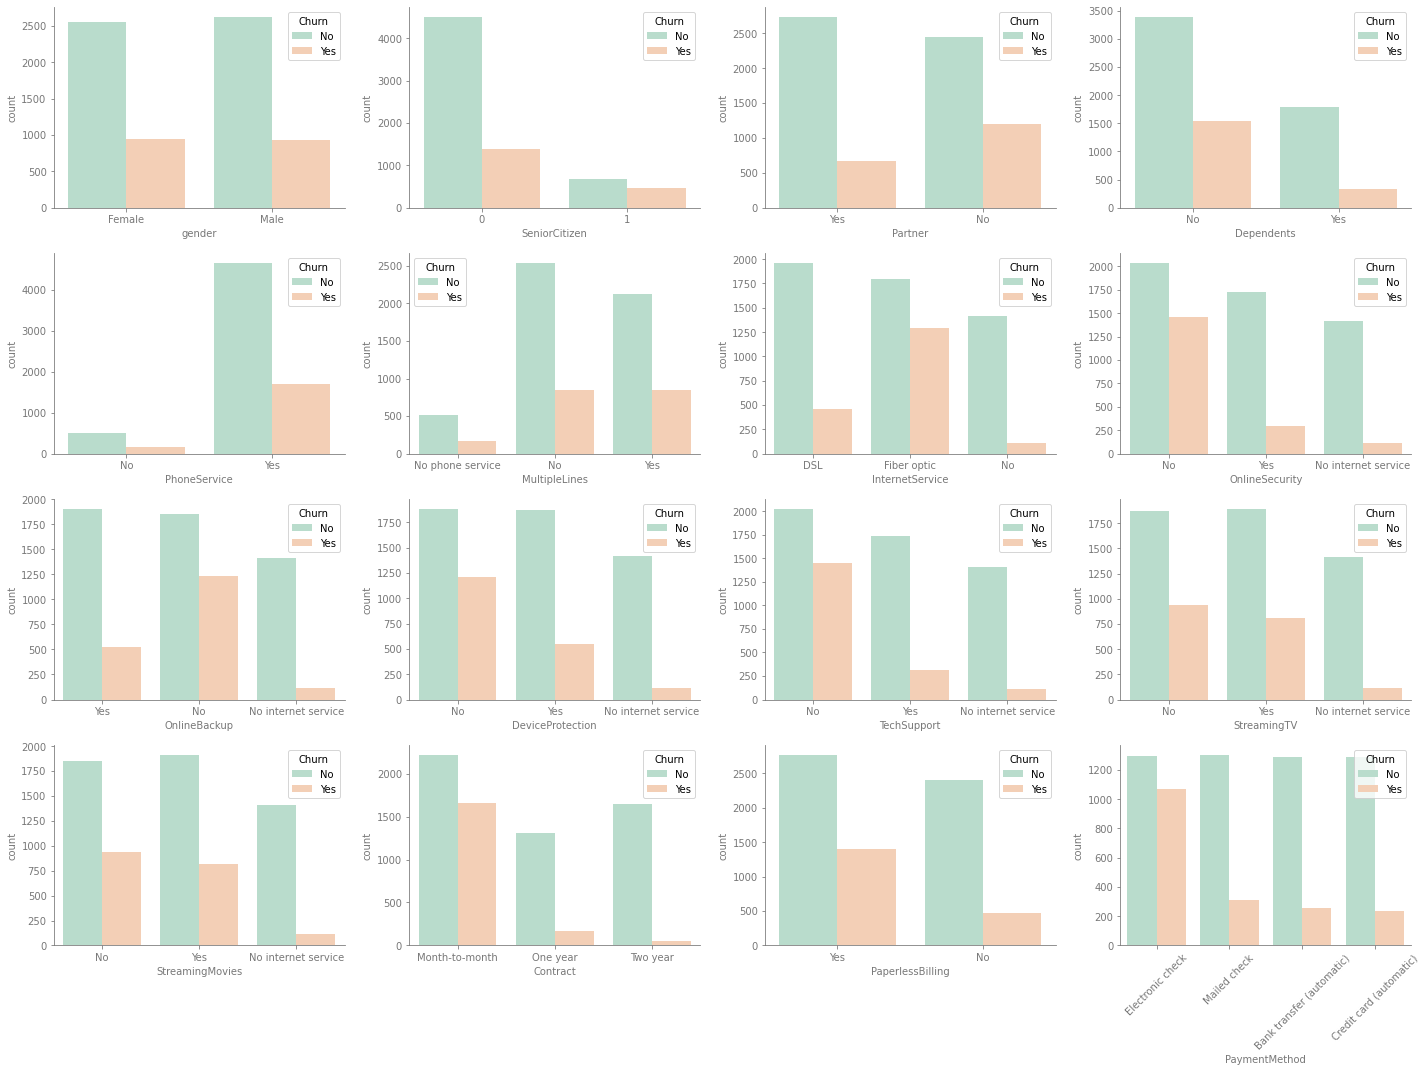

In [ ]:
# definindo os parâmetros de style para o matplotlib
rc_params = {'axes.edgecolor':'#787878', 
             'axes.titlecolor':'#787878', 
             'axes.labelcolor': '#787878', 
             'axes.spines.top': False, 
             'axes.spines.right': False, 
             'xtick.color': '#787878', 
             'ytick.color': '#787878',
             'axes.titleweight': 'bold',
             'axes.titlesize': 12,
             'axes.titlepad': 12
             }

# rc_context é um gerenciador de contextos
# setando os parâmetros no matplotlib
with plt.rc_context(rc_params):

  # instanciando a classe figure e axes
  fig, ax = plt.subplots(nrows = 4, ncols = 4, figsize = (20,15))

  # definindo um contandor para pecorrer o axes
  cont_row = 0
  cont_col = 0

  # criando um loop para gerar um gráfico de feature categórica com exceção do churn
  for cat_feature in df_var_trat["feature"].loc[(df_var_trat['Categórico'] == 1) & (df_var_trat['feature'] != "Churn") ].to_list():

    # plotando um gráfico de contador para cada feature e separando por churn
    sns.countplot(x=cat_feature, data=df, ax=ax[cont_row, cont_col], hue="Churn", palette="Pastel2")

    # definindo uma lógica de incremento nos contadores do axes
    if cont_col == 3:
      cont_col = 0
      cont_row = cont_row + 1
    else:
      cont_col = cont_col + 1

  # rotaciona o eixo x da variável PaymentMethod
  plt.xticks(rotation = 45)

  # exibindo o gráfico
  plt.tight_layout()

### A partir dos gráficos, podemos concluir que:

* O gênero dos consumidores estão balanceados tanto em termos de quantidade de homens e mulheres quanto em quantidade de churn;

* Clientes que não são casados e não possuem dependentes tem maior probabilidade de abandonar os serviços;

* O pacote oferecido de internet gera uma maior probabilidade de clientes abandonarem o serviço. Como podermos observar, cliente que não possuem internet tendem a permanecer mais tempo com a empresa. Vale destacar também que os clientes buscam sempre pacotes que ofereçam o melhor custo benefício, por isso, quanto menor o benefício oferecido (backup online, suporte técnico, streaming e etc) menor as chances de reter o cliente;

* A qualidade do serviço deve ser considerada na estratégia de reter o cliente, pois podemos observar uma taxa de churn considerável para os consumidores que possuem streaming e internet de fibra ótica;

* Contratos de serviço mais arriscados (month-to-month) tendem a gerar uma taxa de churn maior;

* A forma de pagamento do tipo eletrônico check e cobrança de pagamento que não utilizam papel tende a aumentar a probabilidade de clientes abandonarem o serviço.

Vamos avaliar o histograma das variáveis numéricas com intuito de extrair alguns insights.

### Explorando variável de destino (churn)

In [ ]:
target_dest = df["Churn" ].value_counts().to_frame() 
target_dest = target_dest.reset_index() 
target_dest = target_dest.rename(columns={ 'index' : 'Category' }) 
fig = px.pie(target_dest, values = 'Churn' , names= 'Category' , color_discrete_sequence=[ "green" , "red" ], 
             title= 'Distribuição de Churn' ) 
fig.show()

### Visualizando histogramas das variáveis numéricas

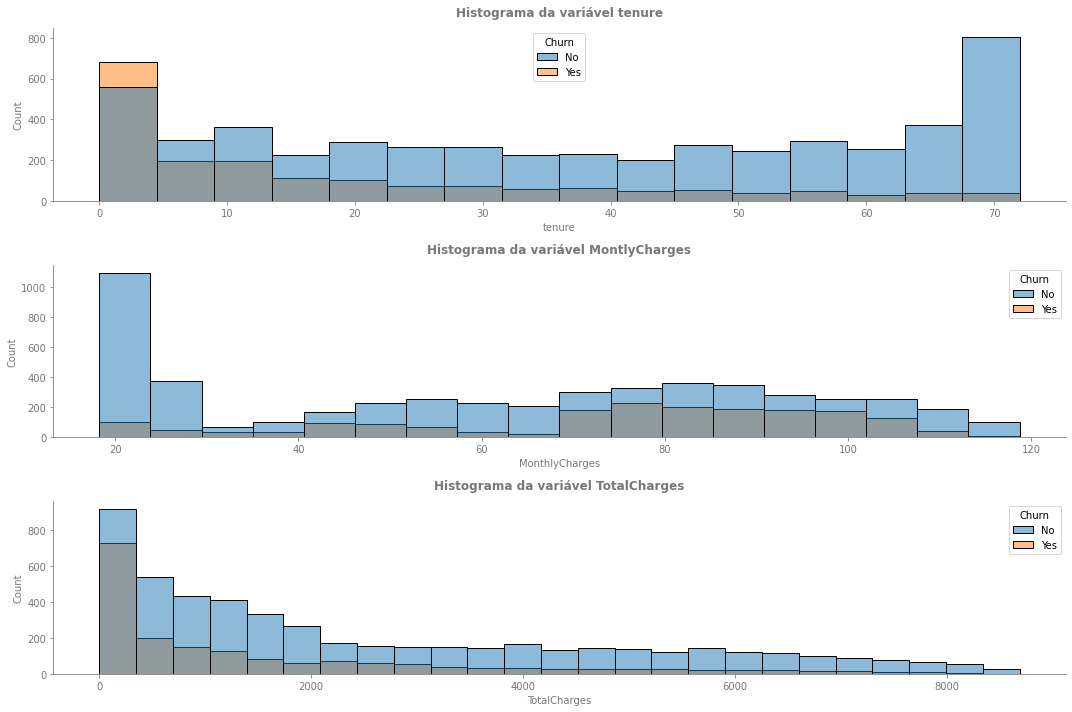

In [ ]:
# setando os parâmetros no matplotlib
with plt.rc_context(rc_params):

  # instanciando o objeto figure e axes
  fig, ax = plt.subplots( nrows=3, ncols=1, figsize=(15,10))

  # criando um histograma para a variável tenure
  sns.histplot(data=df_trat, x='tenure', ax=ax[0], hue="Churn")

  # setando o título do gráfico
  ax[0].set_title("Histograma da variável tenure")

  # criando um histograma para variável MontlyCharges
  sns.histplot(data=df_trat, x = 'MonthlyCharges', ax=ax[1], hue="Churn")

  # setando o título do gráfico
  ax[1].set_title("Histograma da variável MontlyCharges")

  # criando um histograma para a variável TotalCharges
  sns.histplot(data=df_trat, x='TotalCharges', ax=ax[2], hue="Churn")

  # setando o título do gráfico
  ax[2].set_title("Histograma da variável TotalCharges")

  # exibindo o gráfico
  plt.tight_layout()

* As variáveis **tenure** e **TotalCharges** estão relacionadas indiretamente e transmitem o mesmo insight. Portanto, estas variáveis representam a fidelização do cliente, ou seja, quanto mais tempo uma pessoa for consumidora da empresa, maior a taxa de retenção do cliente;

* Quanto mais caro for a mensalidade pelo serviço, maior a chance de perder o cliente. Consumidores irão buscar sempre um serviço/produto que tenha o melhor custo e benefício.

## Balanceamento de variáveis em relação ao alvo Churn

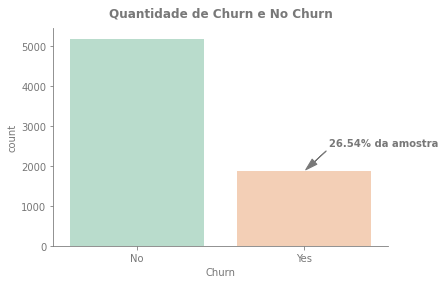

In [ ]:
# setando os parâmetros no matplotlib
with plt.rc_context(rc_params):

  # instanciando a Figure e Axes
  fig, ax = plt.subplots()

  # criando o gráfico de countplot
  sns.countplot(x = 'Churn', 
                data = df_trat,
                ax = ax,
                palette = "Pastel2")
  
  # exibindo o título
  ax.set_title("Quantidade de Churn e No Churn")

  # armazena o % da amostra
  percentual_churn = round((df_trat['Churn'].value_counts()[1] / df_trat.shape[0])*100,2)

  # criar uma informação no gráfico
  ax.annotate(str(percentual_churn) + "% da amostra", 
              xy = (1, df_trat['Churn'].value_counts()[1]), 
              xytext = (25,25), 
              color = "#787878",
              weight = 'bold', 
              textcoords='offset points',
              arrowprops=dict(color = '#787878',  shrink= 0.05, width = 0.01, headwidth = 7))

  # exibindo o gráfico
  plt.show()

Como mostrado no gráfico, os dados relacionados com a variável alvo churn está desbalanceada, visto que apenas 26,54% dos dados totais estão relacionados com consumidores que cancelaram o serviço.

Isto gera um problema durante a predição do modelo de machine learning, porque é mais cômodo para o algoritmo classificar a maioria dos casos como no churn. Diante disto, será necessário balancear amostra. Este passo será mostrado e explicado durante a fase de preparação dos dados.

# Pré-processamento dos dados 

Para trabalhar com os modelos de Machine Learning será necessário transformar as variáveis categóricas em valores numéricos, a ferramenta **LabelEncoder** do Sklearn consegue fazer isso automaticamente, transformando as variáveis binárias em 0 e 1.

Mas também existem as variáveis categóricas não binárias e para elas pode-se utilizar o método do Pandas **get.dummies** para convertê-las.

Para facilitar o processo futuro, será armazenado o nome das variáveis categóricas, binárias e numéricas em uma lista.

In [ ]:
# armazenando as variáveis categóricas e não binárias
cat_features = df_var_trat['feature'].loc[ (df_var_trat['Categórico'] == 1) & (df_var_trat['Binário'] == 0) ].to_list()

# armazenando as variáveis binárias
bin_features = df_var_trat['feature'].loc[ df_var_trat['Binário'] == 1 ].to_list()

# armazenando as variáveis numéricas
num_features = df_var_trat['feature'].loc[ df_var_trat['Categórico'] == 0 ].to_list()

Com o nome das features armazenadas em listas de acordo com seu tipo, aplica-se as codificações nas variáveis categóricas e binárias. 

Deve-se remover a variável **SeniorCitizen** por já estar codificada.

In [ ]:
# removendo a variável SeniorCitizen
bin_features.remove("SeniorCitizen")

# instanciando a LabelEncorder
le = LabelEncoder()

# aplicando o LabelEncoder no dataframe p/ var binárias
for bin_feature in bin_features:

  # aplicando o método fit_transform para codificação
  df_trat[bin_feature] = le.fit_transform(df_trat[bin_feature])

# aplicando o método get_dummies nas variáveis categóricas
df_trat = pd.get_dummies(data = df_trat, columns = cat_features)

In [ ]:
df_trat.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,0,0,1,0,1,0,0,0,1,0,0,0,0,1,29.85,29.85,0,1,0,0,1,0,0,0,0,1,0
1,5575-GNVDE,1,0,0,0,34,1,0,1,0,1,0,0,0,0,56.95,1889.50,0,1,0,0,0,1,0,0,0,0,1
2,3668-QPYBK,1,0,0,0,2,1,0,1,1,0,0,0,0,1,53.85,108.15,1,1,0,0,1,0,0,0,0,0,1
3,7795-CFOCW,1,0,0,0,45,0,0,1,0,1,1,0,0,0,42.30,1840.75,0,1,0,0,0,1,0,1,0,0,0
4,9237-HQITU,0,0,0,0,2,1,0,0,0,0,0,0,0,1,70.70,151.65,1,0,1,0,1,0,0,0,0,1,0


## Treino e Teste

Este passo é importante para ajustar os modelos de machine learning com base no dataset de treino, fazer todas as otimizações necessárias, escolher o melhor modelo com base na sua performance para que no final se possa validar o nível de generalização do modelo com base em dados desconhecidos (teste).

Deve-se dividir os dados em treino e teste, definindo os valores de X (variáveis independentes) e Y (Churn - variável alvo). A variável customerID vai ser retirada por não agregar valor ao modelo.

In [ ]:
# definindo os valores de X e Y e dropando 'customerID' e 'Churn' do modelo de treino
X = df_trat.drop(['customerID', 'Churn'], axis = 1)
Y = df_trat['Churn']

# dividindo o dataset em treino e test
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y, 
                                                    shuffle = True, 
                                                    stratify = Y,
                                                    random_state = 42)

Balanceando os dados para evitar enviesamentos e limite a capacidade de generalizar. 

Para isso será utilizado a técnica de **under-sampling** pois ela reduz o desbalanceamento do dataset focando na classe majoritária. Ou seja, elimina aleatoriamente entradas da classe com maior número de ocorrências.

In [ ]:
# instanciando o objeto RandomUnderSampler()
rus = RandomUnderSampler()

# balanceando a amostra
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

# transformando o array X em dataframe e y em série
X_train_rus = pd.DataFrame(X_train_rus, columns = X_train.columns)
y_train_rus = pd.Series(y_train_rus)

## Escolha do melhor modelo de Machine Learning

Com o processamento de dados finalizado agora é possível implementar os mais variados modelos de Machine Learning em busca daquele que atende melhor a métrica do problema de Churn.

Portanto, a métrica de avaliação escolhida para definir a melhor modelo de acordo com a performance no dataset de validação é o **Recall**, porque para este problema pede-se que o modelo seja capaz de maximizar os acertos de usuários possíveis de Churn, independente do erro.

### Os modelos que serão utilizados são:

* Regressão Logística
* Random Forest
* SVC
* KNN
* XGBoost

### Otimização de Hiperparâmetros

O próximo passo é otimizar os hiperparâmetros de cada modelo, por isso, utilizaremos o algoritmo **GridSearchCV** do Scikit-Learn que visa escolher o melhor conjunto de hiperparâmetros a partir de uma validação cruzada.

Antes de iniciarmos este processo, vamos instanciar e definir os parâmetros do **Kfold** para validação cruzada e criar um passo dentro do pipeline que definiremos para o **GridSearchCV** com o intuito de padronizar as variáveis numéricas.

Vale destacar que é recomendado padronizar apenas as variáveis numéricas para trazer os valores para uma escala padrão, já que alguns modelos de machine learning baseados em distância e gradiente não funcionam de forma adequada para valores com escalas muitos diferentes, podendo gerar um erro na predição.

In [ ]:
# instanciando os parâmetros do Kfold para Validação Cruzada
k_fold = KFold(n_splits = 5, shuffle = True, random_state = 42)

In [ ]:
# escalonando as variáveis numéricas
num_scaled = ColumnTransformer([("Padronizar", StandardScaler(), num_features)],
                         remainder='passthrough')

### Hiperparâmetros para Regressão Logística

* Penalidade 
* Graude de penalidade (C)
* Solver

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
# definindo os passos da pipeline
pipe = make_pipeline(num_scaled, LogisticRegression(random_state = 42))

# definindo os parâmetros para simulação do GridSearch
param_grid = {"logisticregression__penalty": ['l1', 'l2', 'elasticnet', 'none'],
              "logisticregression__C": [100, 10, 1, 0, 0.1, 0.01],
              "logisticregression__solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

# instanciando o GridSearch
clf = GridSearchCV(estimator = pipe,
                   param_grid = param_grid,
                   scoring = 'recall',
                   n_jobs = -1,
                   cv = k_fold)

# ajustando com base no X_train e y_train balanceado
clf.fit(X = X_train_rus, 
        y = y_train_rus)

# imprimindo o melhor parâmetro
clf.best_params_

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning:


305 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  

{'logisticregression__C': 1,
 'logisticregression__penalty': 'l1',
 'logisticregression__solver': 'saga'}

De acordo com **GridSearchCV**, os parâmetros que mais se adequam ao modelo de regressão logística, levando em consideração as particularidades do problema, são:

* Penalidade = 'l2';
* C = 1;
* Solver = 'liblinear'

### Random Forest

O próximo passo é otimizar os hiperparâmetros para Random Forest. Iremos focar em dois hiperparâmetros:

* Máximo de features para dividir o nó em cada árvore (max_features);
* número de árvores (n_estimators).

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# definindo a pipeline
pipe = make_pipeline(num_scaled, RandomForestClassifier(random_state=42))

# parâmetros para simulação do GridSearchCV
param_grid = {"randomforestclassifier__n_estimators": [10, 100, 1000],
              "randomforestclassifier__max_features": ['auto', 'sqrt', 'log2']}

# instanciando o GridSearch
clf = GridSearchCV(estimator = pipe,
                   param_grid = param_grid,
                   scoring = 'recall',
                   n_jobs = -1,
                   cv = k_fold)

# ajustando com base no X_train e y_train balanceado
clf.fit(X = X_train_rus, 
        y = y_train_rus)

# imprimindo o melhor parâmetro
clf.best_params_

{'randomforestclassifier__max_features': 'auto',
 'randomforestclassifier__n_estimators': 1000}

De acordo com **GridSearchCV**, os parâmetros que mais se adequam ao modelo de Random Forest, levando em consideração as particularidades do problema, são:

* max_features = 'auto';
* n_estimators = 1000.

### SVC - Support Vector Machines

O próximo passo é otimizar os hiperparâmetros para SVC. Iremos focar em três hiperparâmetros:

* Kernel;
* Grau de penalização (C);
* Gamma.

In [ ]:
from sklearn.svm import SVC

In [ ]:
# definindo os passos da pipeline
pipe = make_pipeline(num_scaled, SVC(random_state = 42))

#Definindo os parâmetros para simulação do GridSearch
param_grid = {"svc__kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
              "svc__C": [100, 10, 1, 0, 0.1, 0.001],
              "svc__gamma": ['scale', 'auto']}

#Instanciando o GridSearch
clf = GridSearchCV(estimator = pipe,
                   param_grid = param_grid,
                   scoring = 'recall',
                   n_jobs = -1,
                   cv = k_fold)

#Ajustando com base no X_train e y_train balanceado
clf.fit(X = X_train_rus, 
        y = y_train_rus)

#Imprimindo o melhor parâmetro
clf.best_params_

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning:


40 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py", line 255, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "/usr/l

{'svc__C': 0.001, 'svc__gamma': 'scale', 'svc__kernel': 'poly'}

De acordo com **GridSearchCV**, os parâmetros que mais se adequam ao modelo de Random Forest, levando em consideração as particularidades do problema, são:

* C = 0.001;
* gamma = 'Scale';
* kernel = 'poly'.

### KNN - K-ésimo Vizinho mais Próximo

O próximo passo é otimizar os hiperparâmetros para KNN. Iremos focar em três hiperparâmetros:

* número de vizinhos (n_neighbors);
* pesos de cada ponto (weights);
* métrica de distância (metric).

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# definindo os passos da pipeline
pipe = make_pipeline(num_scaled, KNeighborsClassifier())

# definindo os parâmetros para simulação do GridSearch
param_grid = {"kneighborsclassifier__n_neighbors": [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
              "kneighborsclassifier__metric": ["euclidean", "manhattan", "minkowski"],
              "kneighborsclassifier__weights": ['uniform', 'distance']}

# instanciando o GridSearch
clf = GridSearchCV(estimator = pipe,
                   param_grid = param_grid,
                   scoring = 'recall',
                   n_jobs = -1,
                   cv = k_fold)

# ajustando com base no X_train e y_train balanceado
clf.fit(X = X_train_rus, 
        y = y_train_rus)

# imprimindo o melhor parâmetro
clf.best_params_

{'kneighborsclassifier__metric': 'manhattan',
 'kneighborsclassifier__n_neighbors': 17,
 'kneighborsclassifier__weights': 'uniform'}

De acordo com **GridSearchCV**, os parâmetros que mais se adequam ao modelo de KNN, levando em consideração as particularidades do problema, são:

* metric = 'manhattan';
* n_neighbors = 15;
* weights = 'uniform'.

### XGBoost

O próximo passo é otimizar os hiperparâmetros para XGBoost. Iremos focar em quatro hiperparâmetros:

* Número de árvores (n_estimators);
* Taxa de aprendizagem (learning_rate);
* % do subconjunto de dados a serem considerados em cada árvore (subsample);
* Profundidade de cada árvore (max_depth).

In [ ]:
from xgboost import XGBClassifier

In [ ]:
# definindo os passos da pipeline
pipe = make_pipeline(num_scaled, XGBClassifier(random_state = 42))

# definindo os parâmetros para simulação do GridSearch
param_grid = {"xgbclassifier__n_estimators": [10, 100, 1000],
              "xgbclassifier__learning_rate": [0.001, 0.01, 0.1],
              "xgbclassifier__subsample": [0.5, 0.7, 1],
              "xgbclassifier__max_depth": [3, 7, 9]}

# instanciando o GridSearch
clf = GridSearchCV(estimator = pipe,
                   param_grid = param_grid,
                   scoring = 'recall',
                   n_jobs = -1,
                   cv = k_fold)

# ajustando com base no X_train e y_train balanceado
clf.fit(X = X_train_rus, 
        y = y_train_rus)

# imprimindo o melhor parâmetro
clf.best_params_

{'xgbclassifier__learning_rate': 0.1,
 'xgbclassifier__max_depth': 3,
 'xgbclassifier__n_estimators': 10,
 'xgbclassifier__subsample': 0.7}

De acordo com **GridSearchCV**, os parâmetros que mais se adequam ao modelo de **XGboost**, levando em consideração as particularidades do problema, são:

* learning_rate = 0.1;
* max_depth = 3;
* n_estimators = 10;
* subsample = 0.7.

## Definindo o melhor modelo

Após a otimização dos hiperparâmetros dos modelos escolhidos, vamos avaliar o melhor modelo com base na métrica recall obtida a partir do algoritmo de cross-validation do Scikit-learn.

In [ ]:
# criando uma lista vazia para armazenar os valores das métricas e o nome do modelo
name_model = []
recall = []

# instanaciando os modelos com os hiperparâmetros otimizados
model_rl = LogisticRegression(C = 1, 
                              solver = "liblinear",
                              penalty = "l2",
                              random_state = 42)

model_rf = RandomForestClassifier(n_estimators = 1000,
                                  max_features = 'auto',
                                  random_state = 42)

model_svc = SVC(C = 0.001,
                kernel = 'poly',
                gamma = 'scale',
                random_state = 42)

model_knn = KNeighborsClassifier(n_neighbors = 15,
                                 metric = 'manhattan',
                                 weights = 'uniform')

model_xgb = XGBClassifier(learning_rate = 0.1,
                          max_depth = 3,
                          n_estimators = 10,
                          subsample = 0.7,
                          random_state = 42)

# criando um loop para aplicar o cross_validation em cada modelo e armazenar o resultado
for model in [model_rl, model_rf, model_svc, model_knn, model_xgb]:

  # criando um pipeline com a padronização + modelo
  pipe = make_pipeline(num_scaled, model)

  # aplicando o cross_validation para calcular o score
  score = cross_val_score(estimator = pipe,
                          X = X_train_rus,
                          y = y_train_rus,
                          scoring = 'recall',
                          cv = k_fold)
  
  # armazenando o nome do modelo
  name_model.append(model.__class__.__name__)

  # armazenando o score do modelo
  recall.append(score.mean())

# convertendo a estrutura de lista para um dataframe
df_model = pd.DataFrame(data = recall, 
                        index = name_model, 
                        columns = ['Recall'])

# imprmindo a tabela de resultado
df_model

,Recall
LogisticRegression,0.803517
RandomForestClassifier,0.776382
SVC,0.934685
KNeighborsClassifier,0.837101
XGBClassifier,0.826440




A partir da validação cruzada, podemos notar que o modelo que melhor responde a métrica recall para o problema de Churn é o SVC. Porém, vamos testar mais um modelo que é resultante de uma combinação entre mais de um estimador.

Este modelo é chamado de ensemble e para possibilitar melhor utilização, temos que considerar modelos que se baseiam em técnicas diferentes para predizer a variável alvo. Portanto, iremos usar como base os seguintes modelos:

* Regressão logística - Gradiente descendente;
* SVC - Encontra um hiperplano de separação entre as classes da variável alvo;
* KNN - Distância;
* XGBoost - Árvore de decisão.

In [ ]:
# importando a biblioteca do método ensemble
from sklearn.ensemble import VotingClassifier

# armazenando os modelos
model_ensemble = [('rl', model_rl),
                  ('svc', model_svc),
                  ('knn', model_knn),
                  ('XGboost', model_xgb)]

# instanciando o modelo ensemble
voting_clf = VotingClassifier(estimators = model_ensemble)

# criando um pipeline com a padronização + modelo
pipe = make_pipeline(num_scaled, voting_clf)

# aplicando o cross_validation para calcular o score
score = cross_val_score(estimator = pipe,
                        X = X_train_rus,
                        y = y_train_rus,
                        scoring = 'recall',
                        cv = k_fold)

# armazenando o nome do modelo
name_model.append("Ensemble")

# armazenando o resultado do score
recall.append(score.mean())

# convertendo a estrutura de lista para um dataframe
df_model = pd.DataFrame(data = recall, 
                        index = name_model, 
                        columns = ['Recall'])

# imprmindo a tabela de resultado
df_model

,Recall
LogisticRegression,0.803517
RandomForestClassifier,0.776382
SVC,0.934685
KNeighborsClassifier,0.837101
XGBClassifier,0.826440
Ensemble,0.825638


Mesmo com a adição do método ensemble, o modelo SVC ainda continua sendo o melhor modelo com base na métrica recall. Portanto, o próximo passo é aplicarmos no dataset de teste para avaliarmos a capacidade de predição do modelo frente à dados desconhecidos.

## Avaliação do Modelo Escolhido nos Dados de Teste

O próximo passo é avaliarmos a performance do modelo escolhido em relação aos dados de teste.

              precision    recall  f1-score   support

           0       0.93      0.19      0.31      1294
           1       0.30      0.96      0.46       467

    accuracy                           0.39      1761
   macro avg       0.62      0.58      0.38      1761
weighted avg       0.77      0.39      0.35      1761

--------------------------------------------------------------------


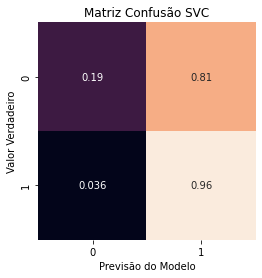

In [ ]:
# copiando o dataframe do X_train e X_test
X_train_rus_scaled = X_train_rus.copy()
X_test_scaled = X_test.copy()

# padronizando as variáveis numéricas
for num_feature in num_features:

  # instanciando o objeto de padronização
  scaler = StandardScaler()

  # ajustando as variáveis numéricas do X_train
  X_train_rus_scaled[num_feature] = scaler.fit_transform(X_train_rus_scaled[num_feature].values.reshape(-1,1))

  # ajustando as variáveis numéricas de X_test com os mesmos parâmetros do X_train
  X_test_scaled[num_feature] = scaler.transform(X_test_scaled[num_feature].values.reshape(-1,1))

# instanciando novamente o modelo escolhido
model_svc = SVC(C = 0.001,
                kernel = 'poly',
                gamma = 'scale',
                random_state = 42)

# aplicando o modelo escolhido
model_svc.fit(X = X_train_rus_scaled,
              y = y_train_rus)

# fazendo a previsão com base nos dados de teste
y_pred = model_svc.predict(X_test_scaled)

# Classification Report
print(classification_report(y_test, y_pred))


print("--------------------------------------------------------------------")

# instanciando a figure e axes
fig, ax = plt.subplots()

# plotando a matriz de confusão em um heatmap
sns.heatmap(confusion_matrix(y_test, y_pred, normalize = 'true'), 
            square=True, 
            annot=True, 
            cbar=False,
            ax = ax)

# definindo o nome do eixo x
ax.set_xlabel("Previsão do Modelo")

# definindo o nome do eixo y
ax.set_ylabel("Valor Verdadeiro")

# definindo o título
ax.set_title("Matriz Confusão SVC")

# exibindo a matriz de confusão
plt.show()

## Conclusão

O modelo de machine learning escolhido se baseou na **métrica recall** com o intuito de acertar o máximo de Churn em clientes que realmente cancelaram o serviço com a empresa de telecomunicações.

Diante disto, **o modelo que melhor se adequou foi o SVC**, alcançando um recall na validação cruzada de 91%. Vale destacar também que seu resultado no dataset de teste (96%) foi próximo ao de validação.

É importante ressaltar que o projeto tem margem para melhoria com feature engineering, feature selection e aplicações de outros modelos preditivos.

Com estas informações, é possível a empresa prever dentre aos novos dados de consumidores quais podem cancelar o serviço e buscar estratégias que antecipem e contribuam para reter e fidelizar o cliente.